# Popular Data Science Questions

Our goal in this project is to use [Data Science Stack Exchange](https://datascience.stackexchange.com/) to determine what content should a data science education company create, based on interest by subject.

# Stack Exchange

<b>What kind of questions are welcome on this site?</b>
On DSSE's help center's [section on questions](https://datascience.stackexchange.com/help/asking) , we can read that we should:

- Avoid subjective questions.
- Ask practical questions about Data Science — there are adequate sites for theoretical questions.
- Ask specific questions.
- Make questions relevant to others.
- All of these characteristics, if employed, should be helpful attributes to our goal.

In the help center we also learned that in addition to the sites mentioned in the Learn section, there are other two sites that are relevant:

- [Open Data](https://opendata.stackexchange.com/help/on-topic) (Dataset requests)
- [Computational Science](https://scicomp.stackexchange.com/help/on-topic) (Software packages and algorithms in applied mathematics)

<b>What, other than questions, does [DSSE](https://datascience.stackexchange.com/) home subdivide into?</b>

On the [home page](https://datascience.stackexchange.com/) we can see that we have four sections:

- [Questions](https://datascience.stackexchange.com/questions) — a list of all questions asked;
- [Tags](https://datascience.stackexchange.com/tags) — a list of tags (keywords or labels that categorize questions);

<img src="SE.png"/>![](SE.png)

- [Users](https://datascience.stackexchange.com/users) — a list of users;
- [Unanswered](https://datascience.stackexchange.com/unanswered) — a list of unanswered questions;

The tagging system used by Stack Exchange looks just like what we need to solve this problem as it allow us to quantify how many questions are asked about each subject.

Something else we can learn from exploring the help center, is that Stack Exchange's sites are heavily moderated by the community; this gives us some confidence in using the tagging system to derive conclusions.

<b>What information is available in each post?</b>

Looking, just as an example, at [this](https://datascience.stackexchange.com/questions/19141/linear-model-to-generate-probability-of-each-possible-output?rq=1) question, some of the information we see is:

For both questions and answers:
- The posts's score;
- The posts's title;
- The posts's author;
- The posts's body;

For questions only:
- How many users have it on their 
- The last time the question as active;
- How many times the question was viewed;
- Related questions;
- The question's tags;

# Exploring the Data

In [1]:
import pandas as pd

questions = pd.read_csv("2019_questions.csv", parse_dates=["CreationDate"])

In [2]:
questions.isnull().sum()

Id                  0
CreationDate        0
Score               0
ViewCount           0
Tags                0
AnswerCount         0
FavoriteCount    7432
dtype: int64

In [3]:
questions.head(5)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,<machine-learning><data-mining>,0,NaN
1,44420,2019-01-23 09:34:01,0,25,<machine-learning><regression><linear-regressi...,0,NaN
2,44423,2019-01-23 09:58:41,2,1651,<python><time-series><forecast><forecasting>,0,NaN
3,44427,2019-01-23 10:57:09,0,55,<machine-learning><scikit-learn><pca>,1,NaN
4,44428,2019-01-23 11:02:15,0,19,<dataset><bigdata><data><speech-to-text>,0,NaN


In [4]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


We see that only FavoriteCount has missing values. A missing value on this column probably means that the question was is not present in any users' favorite list, so we can replace the missing values with zero.

The types seem adequate for every column, however, after we fill in the missing values on FavoriteCount, there is no reason to store the values as floats.

Since the object dtype is a catch-all type, let's see what types the objects in questions["Tags"] are.

In [5]:
questions["Tags"].apply(lambda value: type(value)).unique()

array([<class 'str'>], dtype=object)

We see that every value in this column is a string. On Stack Exchange, each question can only have a maximum of five tags, so one way to deal with this column is to create five columns in questions called Tag1, Tag2, Tag3, Tag4, and Tag5 and populate the columns with the tags in each row.

However, since doesn't help is relating tags from one question to another, we'll just keep them as a list.

# Cleaning the Data

In [6]:
questions["Tags"].head(5)

0                      <machine-learning><data-mining>
1    <machine-learning><regression><linear-regressi...
2         <python><time-series><forecast><forecasting>
3                <machine-learning><scikit-learn><pca>
4             <dataset><bigdata><data><speech-to-text>
Name: Tags, dtype: object

In [7]:
questions.fillna(0,inplace=True)
questions["FavoriteCount"] = questions["FavoriteCount"].astype(int)

In [8]:
questions["Tags"] = questions["Tags"].str.replace("(^<|>$)","").str.split("><")

In [9]:
questions.sample(5)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
5785,52236,2019-05-20 05:32:07,0,197,"[k-means, numpy, distance, geospatial, image]",0,1
7811,54540,2019-06-26 12:36:05,1,35,"[neural-network, deep-learning]",2,1
6542,64233,2019-12-05 00:03:56,6,35,"[classification, multiclass-classification, text]",1,0
3481,48886,2019-04-08 15:55:59,2,22,"[classification, naive-bayes-classifier]",1,0
97,55982,2019-07-19 08:11:19,0,1787,"[machine-learning, python, pandas, lstm]",0,0


# Most Used and Most Viewed

We now focus on determining the most popular tags. We'll do so by considering two different popularity proxies: for each tag we'll count how many times the tag was used, and how many times a question with that tag was viewed.

We could take into account the score, or whether or not a question is part of someone's favorite questions. These are all reasonable options to investigate; but we'll limit the focus of our research to counts and views for now.

In [10]:
tag_counts = dict()

for tag in questions["Tags"].tolist():
    for tags in tag: 
        if tags in tag_counts:
            tag_counts[tags] += 1
        else:
            tag_counts[tags] = 1

tag_counts = pd.DataFrame.from_dict(tag_counts, orient="index")
tag_counts.rename(columns={0:"count"},inplace=True)
tag_count = tag_counts.sort_values("count").tail(20)
tag_count.head(5)

,count
machine-learning-model,224
statistics,234
clustering,257
predictive-modeling,265
r,268


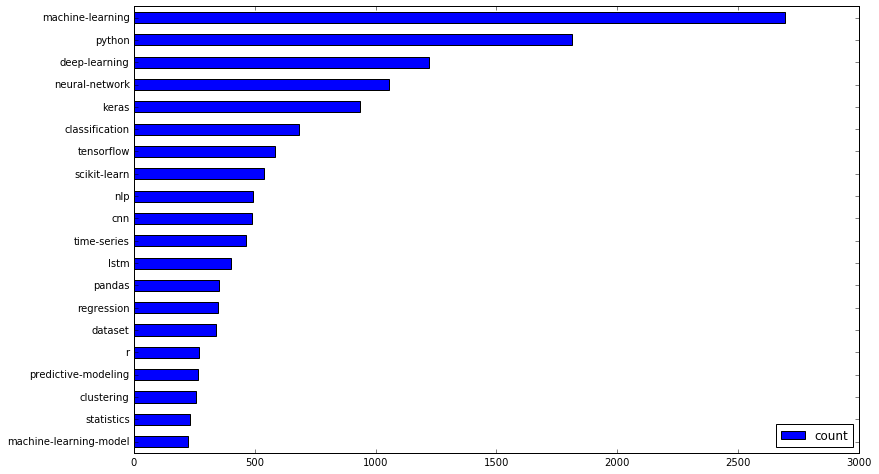

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
tag_count.plot(kind="barh",figsize=(13,8))

Some tags are very, very broad and unlikely to be used for e.g python, R, pandas... Before we go to the conclusion, let's check for the number of views

In [12]:
count_view_tags = dict()

for index,rows in questions.iterrows():
    for tag in rows["Tags"]:
        if tag in count_view_tags:
            count_view_tags[tag] += rows["ViewCount"]
        else:
            count_view_tags[tag] = rows["ViewCount"]
            
count_view_tags = pd.DataFrame.from_dict(count_view_tags, orient="index")
count_view_tags.rename(columns={0:"view_count"},inplace=True)
count_view_tags = count_view_tags.sort_values("view_count").tail(20)

count_view_tags

,view_count
clustering,33928
csv,38654
pytorch,40240
dataset,43151
regression,49451
numpy,49767
time-series,64134
cnn,70349
nlp,71382
lstm,74458


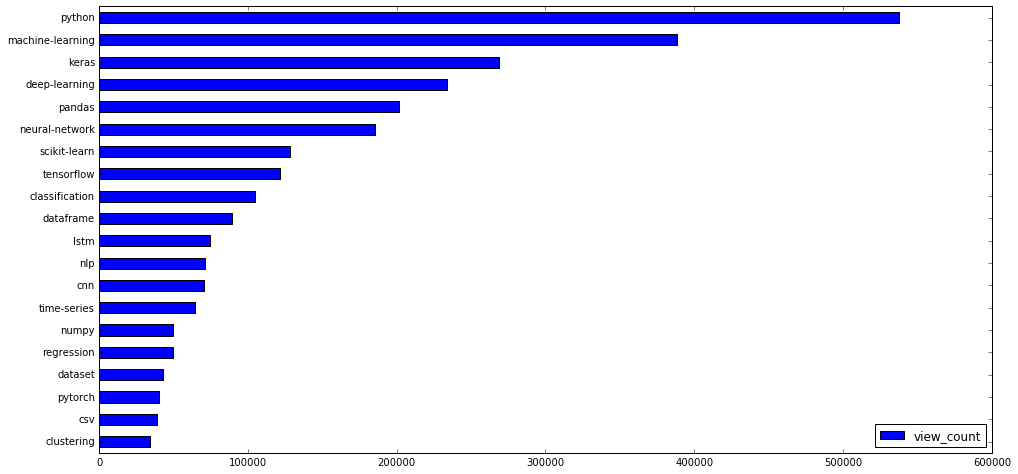

In [13]:
count_view_tags.plot(kind="barh",figsize=(16,8))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f527cc66cc0>],
      dtype=object)

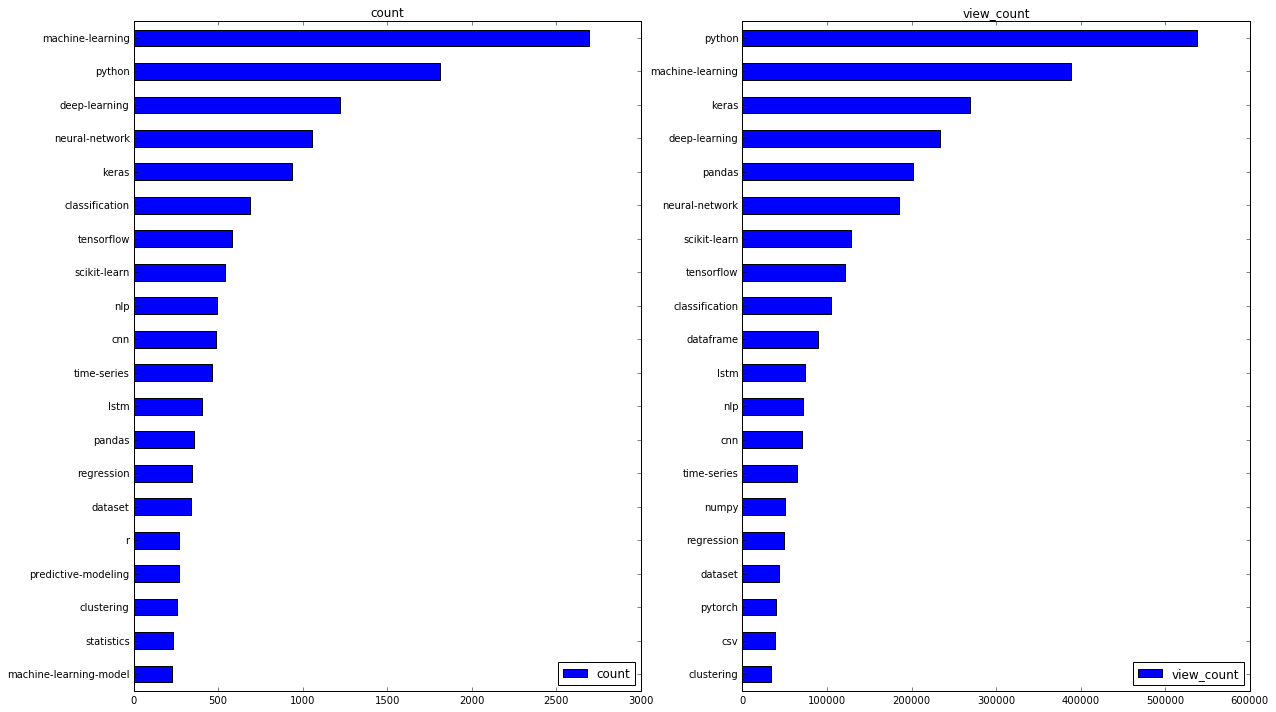

In [14]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(20,12))
tag_count.plot(kind="barh",ax=axes[0],subplots=True)
count_view_tags.plot(kind="barh",ax=axes[1],subplots=True)

# Relations Between Tags

One way to define the relationships between pair of tags is to count how many times they appear together

In [15]:
all_tags = list(tag_counts.index)
all_tags[0:10]

['counter-inference',
 'predict',
 'mcmc',
 'evolutionary-algorithms',
 'inceptionresnetv2',
 'consumerweb',
 'faster-rcnn',
 'class-imbalance',
 'unbalanced-classes',
 'game']

In [16]:
associations = pd.DataFrame(index=all_tags, columns=all_tags)
associations.fillna(0, inplace=True)

In [17]:
for tags in questions["Tags"]:
    associations.loc[tags, tags] += 1

associations.sample(10)

,counter-inference,predict,mcmc,evolutionary-algorithms,inceptionresnetv2,consumerweb,faster-rcnn,class-imbalance,unbalanced-classes,game,...,nltk,csv,linear-algebra,image-segmentation,refit-model,nvidia,google-cloud,usecase,image-classification,generalization
statsmodels,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
movielens,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ndcg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
noisification,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
terminology,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
data-imputation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
machine-translation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
generative-models,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
map-reduce,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
relational-dbms,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
relations_most_used = associations.loc[tag_count.index, tag_count.index]
def style_cells(x):
    helper_df = pd.DataFrame('', index=x.index, columns=x.columns)
    helper_df.loc["time-series", "r"] = "background-color: yellow"
    helper_df.loc["r", "time-series"] = "background-color: yellow"
    for k in range(helper_df.shape[0]):
        helper_df.iloc[k,k] = "color: blue"
    
    return helper_df

relations_most_used.style.apply(style_cells, axis=None)

,machine-learning-model,statistics,clustering,predictive-modeling,r,dataset,regression,pandas,lstm,time-series,cnn,nlp,scikit-learn,tensorflow,classification,keras,neural-network,deep-learning,python,machine-learning
machine-learning-model,224,3,3,21,7,12,8,4,5,7,4,4,18,9,21,17,10,19,37,139
statistics,3,234,3,16,16,17,16,3,1,22,1,3,6,0,19,3,11,12,35,89
clustering,3,3,257,0,16,5,2,5,3,20,0,9,24,0,12,0,8,2,45,61
predictive-modeling,21,16,0,265,13,7,28,4,13,31,6,1,12,6,27,11,13,32,35,123
r,7,16,16,13,268,6,10,2,3,22,2,4,1,1,10,10,9,5,24,63
dataset,12,17,5,7,6,340,6,14,7,6,11,11,9,9,28,13,20,32,53,99
regression,8,16,2,28,10,6,347,6,11,24,6,2,37,9,34,31,42,21,59,119
pandas,4,3,5,4,2,14,6,354,7,19,1,3,37,3,3,3,1,1,244,62
lstm,5,1,3,13,3,7,11,7,402,87,24,19,2,43,20,133,69,103,61,71
time-series,7,22,20,31,22,6,24,19,87,466,8,0,12,9,25,51,33,44,105,131


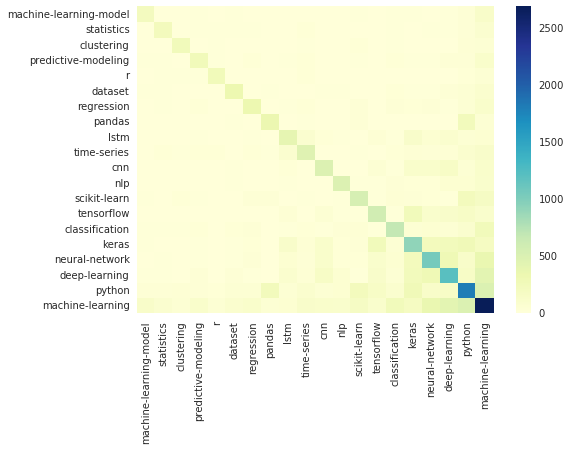

In [19]:
import seaborn as sns
sns.heatmap(relations_most_used, cmap="YlGnBu",annot=False)

as per heatmap, the most used tags seem to have strong relationships. The darkest color means the strongest relationship they have.

However, we cannot conclude that they actually affect on each other. For example, many people need to buy bread and a lot of people need to buy milk so they end up purchasing both products together. But purchasing one of them doesn't increase the chances of purchasing the other. 

# Enter Domain Knowledge

After doing research, we notice that <b>keras</b>, <b>tensorflor</b>, <b>scikit-learn</b> are <b>Python</b>'s libraries that allow to use deep learning network

All the tags on DSSE points out that the main domain knowledge here: deep-learning

# Just a Fad?

In [20]:
aq = pd.read_csv("all_questions.csv", parse_dates=["CreationDate"])
aq.head()

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,<python><keras><tensorflow><cnn><probability>
1,45418,2019-02-12 00:50:39,<neural-network>
2,45422,2019-02-12 04:40:51,<python><ibm-watson><chatbot>
3,45426,2019-02-12 04:51:49,<keras>
4,45427,2019-02-12 05:08:24,<r><predictive-modeling><machine-learning-mode...


In [21]:
aq["Tags"] = aq["Tags"].str.replace("^<|>$","").str.split("><")
aq["Tags"].sample(5)

13948    [neural-network, logistic-regression, octave, ...
10372                         [nlp, ngrams, interpolation]
1658       [neural-network, keras, cnn, transfer-learning]
13116             [machine-learning, r, xgboost, sampling]
6712                 [machine-learning, nlp, stanford-nlp]
Name: Tags, dtype: object

In [22]:
def class_deep_learning(tags):
    for tag in tags:
        if tag in ["keras", "neural-network", "lstm", "deep-learning",
                  "tensorflow","scikit-learn","cnn"]:
            return 1
    return 0
    
aq["deep_learning"] = aq["Tags"].apply(class_deep_learning)
aq.tail()

,Id,CreationDate,Tags,deep_learning
21571,36971,2018-08-15 14:19:01,"[statistics, data]",0
21572,36974,2018-08-15 14:40:27,"[machine-learning, neural-network, classifier]",1
21573,36975,2018-08-15 14:53:43,"[machine-learning, classification]",0
21574,36979,2018-08-14 19:31:43,"[tensorflow, python]",1
21575,36985,2018-08-15 17:01:29,"[python, deep-learning, tensorflow]",1


In [23]:
def quarter(date):
    year = str(date.year)[-2:]
    quarter = str(((date.month -1) // 3) + 1)
    return "{f}Q{q}".format(f=year, q=quarter)

aq["quarter"] = aq["CreationDate"].apply(quarter)
aq.sample(5)

aq.shape

(21576, 5)

In [24]:
aq_quarter = aq.groupby("quarter").agg({"deep_learning":["sum","size"]})
aq_quarter.columns = ["DeepLearningQuestions","TotalQuestions"]
aq_quarter["DeepLearning_Rate"] = (aq_quarter["DeepLearningQuestions"] / aq_quarter["TotalQuestions"]) * 100

In [25]:
aq_quarter.reset_index(inplace=True)
aq_quarter.sample(5)

,quarter,DeepLearningQuestions,TotalQuestions,DeepLearning_Rate
18,18Q4,531,1294,41.035549
12,17Q2,226,647,34.930448
13,17Q3,247,714,34.593838
4,15Q2,28,284,9.859155
5,15Q3,45,311,14.469453


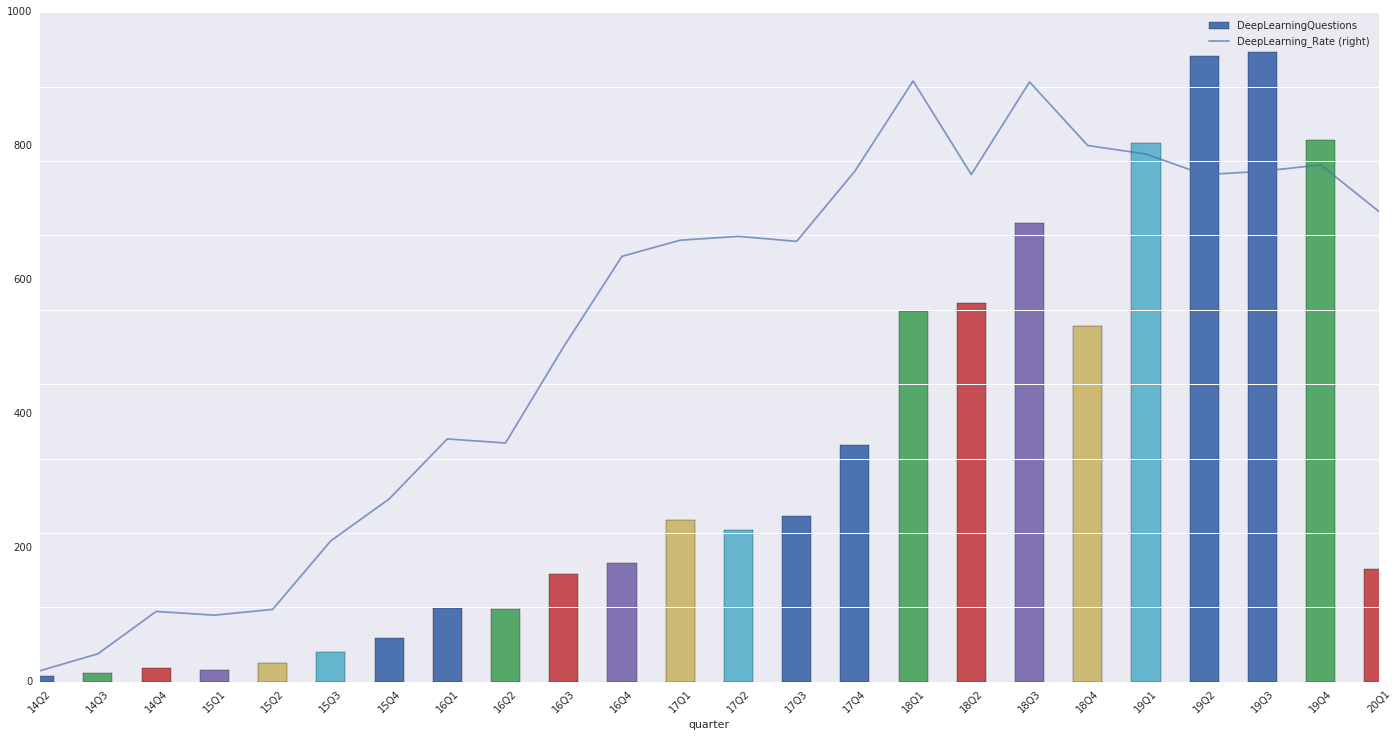

In [26]:
ax1 = aq_quarter.plot(kind="bar", x="quarter", y="DeepLearningQuestions",
                     figsize=(24,12))
ax2 = aq_quarter.plot(kind="line", x="quarter", y="DeepLearning_Rate",
                     ax=ax1, secondary_y=True, linestyle="-",alpha=0.7,
                     rot=45)

for ax in [ax1, ax2]:
    for where in ["top", "right"]:
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)

# Conclusion

It seems that deep learning questions was a high-growth trend since the start of DSSE and it looks like it is plateauing. There is no evidence to suggest that interest in deep learning is decreasing and so we maintain our previous idea of proposing that we create deep learning content.